# Choose whether to ignore warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Load data

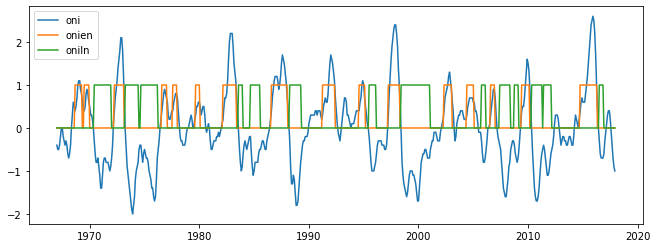

In [2]:
%run wcpfc_load_and_calc.ipynb

# Extra things to load

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import scipy.stats as stats

In [4]:
lon = wf['lon']
lat = wf['lat']

# Define fxns

### Define fxn to calculate regress and correl coeff maps

In [5]:
# - For loop-based fxn for calculating correl and regress coeff map btwn two (time,lat,lon) xr dataarrays
# The following warning ...
# "/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
#  warnings.warn(PearsonRConstantInputWarning())"
# ...is b/c one or both of xnow,ynow had all zeros for non-nan values.
def gettemprcmap_loop(x3dnow,y3dnow,namebasenow):

    # - Initialize nan DataArray same size as x3dnow
    # --> new DataArray takes name of old though, so will need to rename
    # (Apparently you can't initialize empty or full DataArrays yet still: https://github.com/pydata/xarray/issues/277)
    rc2dnow = x3dnow.mean(dim='time') * np.nan
    int2dnow = x3dnow.mean(dim='time') * np.nan
    rcpval2dnow = x3dnow.mean(dim='time') * np.nan
    cc2dnow = x3dnow.mean(dim='time') * np.nan
    ccpval2dnow = x3dnow.mean(dim='time') * np.nan
    stderr2dnow = x3dnow.mean(dim='time') * np.nan

    # - Loop over each lat/lon combo
    for ilat in range(x3dnow.lat.size):
        for ilon in range(x3dnow.lon.size):
            xnow = x3dnow[:,ilat,ilon]
            ynow = y3dnow[:,ilat,ilon]
            # - Get rid of any times where xnow or ynow is nan or inf
            valsnow = (~xr.ufuncs.isnan(xnow))&(~xr.ufuncs.isnan(ynow))&(~xr.ufuncs.isinf(xnow))&(~xr.ufuncs.isinf(ynow))
            if valsnow.sum()>=2:
                #print([ilat,ilon])
                ccnow = stats.pearsonr(xnow[valsnow],ynow[valsnow]) 
                cc2dnow[ilat,ilon] = ccnow[0]
                ccpval2dnow[ilat,ilon] = ccnow[1]
                #[rc2dnow[ilat,ilon], int2dnow[ilat,ilon], cc2dnow[ilat,ilon], pval2dnow[ilat,ilon], 
                # stderr2dnow[ilat,ilon]] = stats.linregress(xnow[valsnow],ynow[valsnow]) 
                linregnow = stats.linregress(xnow[valsnow],ynow[valsnow]) 
                rc2dnow[ilat,ilon] = linregnow[0]
                int2dnow[ilat,ilon] = linregnow[1]
                rcpval2dnow[ilat,ilon] = linregnow[3]
                stderr2dnow[ilat,ilon] = linregnow[4]

    # - Rename
    rc2dnow.name = namebasenow+'_rc'
    int2dnow.name = namebasenow+'_int'
    rcpval2dnow.name = namebasenow+'_rc_pval'
    cc2dnow.name = namebasenow+'_cc'
    ccpval2dnow.name = namebasenow+'_cc_pval'
    stderr2dnow.name = namebasenow+'_stderr'
    
    return [rc2dnow,int2dnow,rcpval2dnow,cc2dnow,ccpval2dnow,stderr2dnow]

### Define fxn to generate Wilcoxon ranksum p-value maps

In [6]:
# - For loop-based fxn for calculating wilcoxon rank sum p-val map btwn two (time,lat,lon) xr dataarrays
def wrspvalmap_loop(x3dnow,y3dnow,namebasenow):

    # - Initialize nan DataArray same size as x3dnow
    # --> new DataArray takes name of old though, so will need to rename
    pval2dnow = xr.full_like(x3dnow.mean(dim='time'), np.nan)

    # - Loop over each lat/lon combo
    for ilat in range(x3dnow.lat.size):
        for ilon in range(x3dnow.lon.size):
            xnow = x3dnow[:,ilat,ilon]
            ynow = y3dnow[:,ilat,ilon]
            # - Get rid of any times where xnow or ynow is nan or inf
            xvalsnow = (~xr.ufuncs.isnan(xnow))&(~xr.ufuncs.isinf(xnow))
            yvalsnow = (~xr.ufuncs.isnan(ynow))&(~xr.ufuncs.isinf(ynow))
            if (xvalsnow.sum()>=1)&(yvalsnow.sum()>=1):
                #print([ilat,ilon])
                wrsnow = stats.ranksums(xnow[xvalsnow],ynow[yvalsnow]) 
                pval2dnow[ilat,ilon] = wrsnow[1]
    
    # - Rename
    pval2dnow.name = namebasenow+'_wrs_pval'
    
    return pval2dnow

### Define fxn to control false discovery rate

In [7]:
# - hmmmm what if pfdrarr-sortedpvalstack is never >=0?
def controlfdr(pval2dnow,alphafdr):
    pvalstack=pval2dnow.stack(x=['lat','lon'])
    pvalstack=pvalstack[pvalstack.notnull()]
    sortedpvalstack = pvalstack.sortby(pvalstack).values
    N = sortedpvalstack.size
    pfdrarr = alphafdr*np.arange(1,N+1)/N
    pthreshfdr = sortedpvalstack[(pfdrarr-sortedpvalstack)>=0].max()
    return pthreshfdr

### Define fxn to find spots where all non-nan values are zero

In [8]:
# - Finds lat and lon where all non-nan time series values are zero
def find_where_all_nonnan_zero(var3din):
    # - Find spatial pts where all non-nan var3din values over time are zero
    var3din_sum=var3din.sum(dim='time', skipna=True).where(~xr.ufuncs.isnan(var3din.mean(dim='time')))
    var3din_sum_zero=var3din_sum.where(var3din_sum==0)
    # - Get lat,lon where zeros are (https://stackoverflow.com/questions/40592630/get-coordinates-of-non-nan-values-of-xarray-dataset)
    var3din_sum_zero_stacked = var3din_sum_zero.stack(x=['lat','lon'])
    var3din_all_zeros=var3din_sum_zero_stacked[var3din_sum_zero_stacked.notnull()]
    # - Look at time series at the computed lats/lons to make sure all non-nan values are zero
    #for i in range(var3din_all_zeros.size):
    #    print(var3din.sel(lat=var3din_all_zeros.lat[i], lon=var3din_all_zeros.lon[i]))
    return [var3din_all_zeros.lon,var3din_all_zeros.lat]

### Define fxn to find spots where p-value is below certain value

In [9]:
# - Finds lat and lon where all p-values are small
def find_where_pval_small(pvalmap,alpha):
    # - Find spatial pts where all p-val are smaller than alpha
    pvalmap_small_nonnan = pvalmap.where(pvalmap<alpha)
    # - Get lat,lon where small p-vals are (https://stackoverflow.com/questions/40592630/get-coordinates-of-non-nan-values-of-xarray-dataset)
    pvalmap_small_nonnan_stacked = pvalmap_small_nonnan.stack(x=['lat','lon'])
    pvalmap_small = pvalmap_small_nonnan_stacked[pvalmap_small_nonnan_stacked.notnull()]
    return [pvalmap_small.lon,pvalmap_small.lat]

# Compute maps

### Compute correl/regress coeff maps

In [10]:
alphafdr = 0.1

[b2svss_cp_tot_rc, _, b2svss_cp_tot_rc_pval,
 b2svss_cp_tot_cc, b2svss_cp_tot_cc_pval, _
]=gettemprcmap_loop(skj_cp_tot,bettoskj_cp_tot,'b2svss_cp_tot')
b2svss_cp_tot_rc_ptf = controlfdr(b2svss_cp_tot_rc_pval,alphafdr)
b2svss_cp_tot_cc_ptf = controlfdr(b2svss_cp_tot_cc_pval,alphafdr)

[bvss_cp_tot_rc, _, bvss_cp_tot_rc_pval,
 bvss_cp_tot_cc, bvss_cp_tot_cc_pval, _
]=gettemprcmap_loop(skj_cp_tot,bet_cp_tot,'bvss_cp_tot')
bvss_cp_tot_rc_ptf = controlfdr(bvss_cp_tot_rc_pval,alphafdr)
bvss_cp_tot_cc_ptf = controlfdr(bvss_cp_tot_cc_pval,alphafdr)

[b2svss_cp_tot_anom_rc, _, b2svss_cp_tot_anom_rc_pval,
 b2svss_cp_tot_anom_cc, b2svss_cp_tot_anom_cc_pval, _
]=gettemprcmap_loop(skj_cp_tot_anom,bettoskj_cp_tot_anom,'b2svss_cp_tot')
b2svss_cp_tot_anom_rc_ptf = controlfdr(b2svss_cp_tot_anom_rc_pval,alphafdr)
b2svss_cp_tot_anom_cc_ptf = controlfdr(b2svss_cp_tot_anom_cc_pval,alphafdr)

[bvss_cp_tot_anom_rc, bvss_cp_tot_anom_int, bvss_cp_tot_anom_rc_pval,
 bvss_cp_tot_anom_cc, bvss_cp_tot_anom_cc_pval, _
]=gettemprcmap_loop(skj_cp_tot_anom,bet_cp_tot_anom,'bvss_cp_tot')
bvss_cp_tot_anom_rc_ptf = controlfdr(bvss_cp_tot_anom_rc_pval,alphafdr)
bvss_cp_tot_anom_cc_ptf = controlfdr(bvss_cp_tot_anom_cc_pval,alphafdr)

### Compute lats/lons where mapped values are always zero

In [11]:
[bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat] = find_where_all_nonnan_zero(bet_cp_tot)
[skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat] = find_where_all_nonnan_zero(skj_cp_tot)

# Question 0a from 9/19/19 in written lab notebook

### Using totals (not anoms)

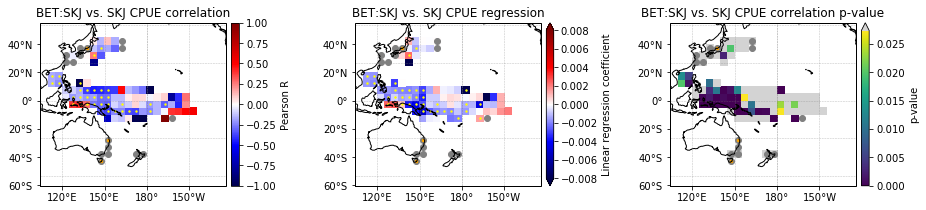

In [12]:
# - Set proj and define axes
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty
for ax in axes:
    exec(open("create_map_bgs.py").read())

# - Plot
b2svss_cp_tot_cc.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap=cm.seismic,
                      cbar_kwargs={'pad': 0.02, 'label': 'Pearson R'});
axes[0].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[0].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(b2svss_cp_tot_cc_pval,b2svss_cp_tot_cc_ptf)
axes[0].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[0].set_xlabel(''); axes[0].set_ylabel('');
axes[0].set_title('BET:SKJ vs. SKJ CPUE correlation')

b2svss_cp_tot_rc.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap=cm.seismic, vmin=-0.008, vmax=0.008,
                      cbar_kwargs={'pad': 0.02, 'label': 'Linear regression coefficient', 'extend': 'both'});
axes[1].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[1].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(b2svss_cp_tot_rc_pval,b2svss_cp_tot_rc_ptf)
axes[1].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[1].set_xlabel(''); axes[1].set_ylabel('');
axes[1].set_title('BET:SKJ vs. SKJ CPUE regression')

cmapnow = cm.viridis
cmapnow.set_over('lightgray')
b2svss_cp_tot_rc_pval.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap=cmapnow, vmax=b2svss_cp_tot_cc_ptf,
                      cbar_kwargs={'pad': 0.02, 'label': 'p-value', 'extend': 'max'});
axes[2].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[2].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
axes[2].set_xlabel(''); axes[2].set_ylabel('');
axes[2].set_title('BET:SKJ vs. SKJ CPUE correlation p-value');

#fig.savefig(figpath + 'question0a_b2svsscpue_tots_correl_regress.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Using anoms

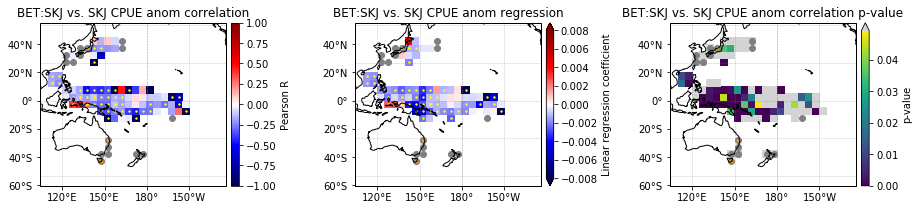

In [29]:
# - Set proj and define axes
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty
for ax in axes:
    exec(open("create_map_bgs.py").read())

# - Plot
b2svss_cp_tot_anom_cc.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap=cm.seismic,
                      cbar_kwargs={'pad': 0.02, 'label': 'Pearson R'});
axes[0].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[0].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(b2svss_cp_tot_anom_cc_pval,b2svss_cp_tot_anom_cc_ptf)
axes[0].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[0].set_xlabel(''); axes[0].set_ylabel('');
axes[0].set_title('BET:SKJ vs. SKJ CPUE anom correlation')

b2svss_cp_tot_anom_rc.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap=cm.seismic, vmin=-0.008, vmax=0.008,
                      cbar_kwargs={'pad': 0.02, 'label': 'Linear regression coefficient', 'extend': 'both'});
axes[1].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[1].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(b2svss_cp_tot_anom_rc_pval,b2svss_cp_tot_anom_rc_ptf)
axes[1].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[1].set_xlabel(''); axes[1].set_ylabel('');
axes[1].set_title('BET:SKJ vs. SKJ CPUE anom regression')

cmapnow = cm.viridis
cmapnow.set_over('lightgray')
b2svss_cp_tot_anom_rc_pval.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap=cmapnow, vmax=b2svss_cp_tot_anom_cc_ptf,
                      cbar_kwargs={'pad': 0.02, 'label': 'p-value', 'extend': 'max'});
axes[2].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[2].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
axes[2].set_xlabel(''); axes[2].set_ylabel('');
axes[2].set_title('BET:SKJ vs. SKJ CPUE anom correlation p-value');

#fig.savefig(figpath + 'question0a_b2svsscpue_anom_correl_regress.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

# Question 1a from 9/19/19 in written lab notebook

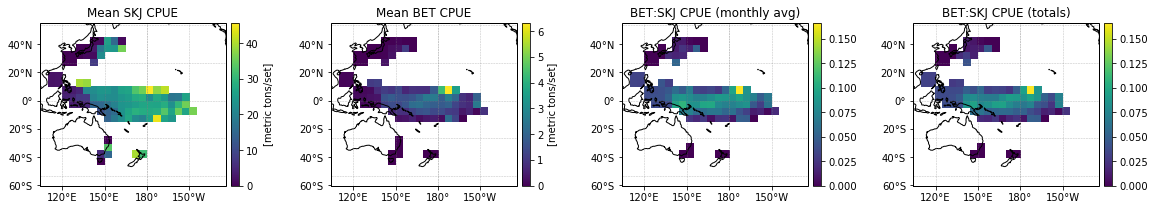

In [85]:
# - Set proj and define axes
fig,axes = plt.subplots(nrows=1, ncols=4, figsize=(20,3), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty
for ax in axes:
    exec(open("create_map_bgs.py").read())

# - Plot
unitsnow = '[metric tons/set]'

skj_cp_tot_mean.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap=cm.viridis,
                      cbar_kwargs={'pad': 0.02, 'label': unitsnow});
axes[0].set_xlabel(''); axes[0].set_ylabel('');
axes[0].set_title('Mean SKJ CPUE')

bet_cp_tot_mean.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap=cm.viridis,
                      cbar_kwargs={'pad': 0.02, 'label': unitsnow});
axes[1].set_xlabel(''); axes[1].set_ylabel('');
axes[1].set_title('Mean BET CPUE')

bettoskj_cp_tot_mean.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap=cm.viridis,
                      cbar_kwargs={'pad': 0.02, 'label': ''});
axes[2].set_xlabel(''); axes[2].set_ylabel('');
axes[2].set_title('BET:SKJ CPUE (monthly avg)');

bettoskj_totcp_tot.plot(ax=axes[3], transform=ccrs.PlateCarree(), cmap=cm.viridis,
                      cbar_kwargs={'pad': 0.02, 'label': ''});
axes[3].set_xlabel(''); axes[3].set_ylabel('');
axes[3].set_title('BET:SKJ CPUE (totals)');

#fig.savefig(figpath + 'question1a_meanbscpue.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

# Question 1b from 9/19/19 in written lab notebook

### Using totals (not anoms)

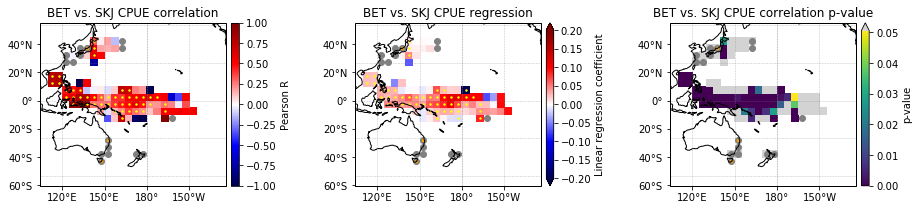

In [28]:
# - Set proj and define axes
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty
for ax in axes:
    exec(open("create_map_bgs.py").read())

# - Plot
bvss_cp_tot_cc.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap=cm.seismic,
                      cbar_kwargs={'pad': 0.02, 'label': 'Pearson R'});
axes[0].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[0].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(bvss_cp_tot_cc_pval,bvss_cp_tot_cc_ptf)
axes[0].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[0].set_xlabel(''); axes[0].set_ylabel('');
axes[0].set_title('BET vs. SKJ CPUE correlation')

bvss_cp_tot_rc.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap=cm.seismic, vmin=-0.2, vmax=0.2,
                      cbar_kwargs={'pad': 0.02, 'label': 'Linear regression coefficient', 'extend': 'both'});
axes[1].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[1].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(bvss_cp_tot_rc_pval,bvss_cp_tot_rc_ptf)
axes[1].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[1].set_xlabel(''); axes[1].set_ylabel('');
axes[1].set_title('BET vs. SKJ CPUE regression')

cmapnow = cm.viridis
cmapnow.set_over('lightgray')
bvss_cp_tot_rc_pval.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap=cmapnow, vmax=bvss_cp_tot_rc_ptf,
                      cbar_kwargs={'pad': 0.02, 'label': 'p-value', 'extend': 'max'});
axes[2].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[2].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
axes[2].set_xlabel(''); axes[2].set_ylabel('');
axes[2].set_title('BET vs. SKJ CPUE correlation p-value');

#fig.savefig(figpath + 'question1b_bvsscpue_tots_correl_regress.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Using anoms

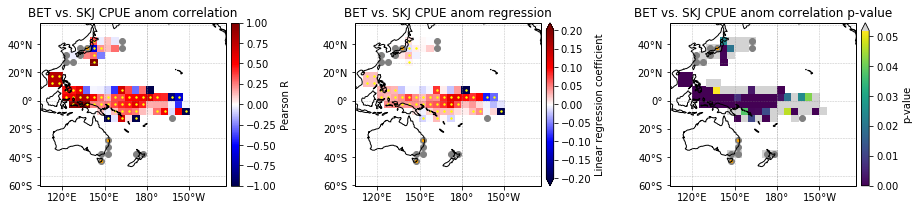

In [26]:
# - Set proj and define axes
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty
for ax in axes:
    exec(open("create_map_bgs.py").read())

# - Plot
bvss_cp_tot_anom_cc.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap=cm.seismic,
                      cbar_kwargs={'pad': 0.02, 'label': 'Pearson R'});
axes[0].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[0].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(bvss_cp_tot_anom_cc_pval,bvss_cp_tot_anom_cc_ptf)
axes[0].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[0].set_xlabel(''); axes[0].set_ylabel('');
axes[0].set_title('BET vs. SKJ CPUE anom correlation')

bvss_cp_tot_anom_rc.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap=cm.seismic, vmin=-0.2, vmax=0.2,
                      cbar_kwargs={'pad': 0.02, 'label': 'Linear regression coefficient', 'extend': 'both'});
axes[1].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[1].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
[signiflonnow,signiflatnow]=find_where_pval_small(bvss_cp_tot_anom_rc_pval,bvss_cp_tot_anom_rc_ptf)
axes[1].scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
axes[1].set_xlabel(''); axes[1].set_ylabel('');
axes[1].set_title('BET vs. SKJ CPUE anom regression')

cmapnow = cm.viridis
cmapnow.set_over('lightgray')
bvss_cp_tot_anom_rc_pval.plot(ax=axes[2], transform=ccrs.PlateCarree(), cmap=cmapnow, vmax=bvss_cp_tot_anom_rc_ptf,
                      cbar_kwargs={'pad': 0.02, 'label': 'p-value', 'extend': 'max'});
axes[2].scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());
axes[2].scatter(skj_cp_tot_all_zeros_lon, skj_cp_tot_all_zeros_lat, c='orange', s=6, transform=ccrs.PlateCarree());
axes[2].set_xlabel(''); axes[2].set_ylabel('');
axes[2].set_title('BET vs. SKJ CPUE anom correlation p-value');

#fig.savefig(figpath + 'question1b_bvsscpue_anom_correl_regress.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

# Question 2a seasons from 9/19/19 in written lab notebook

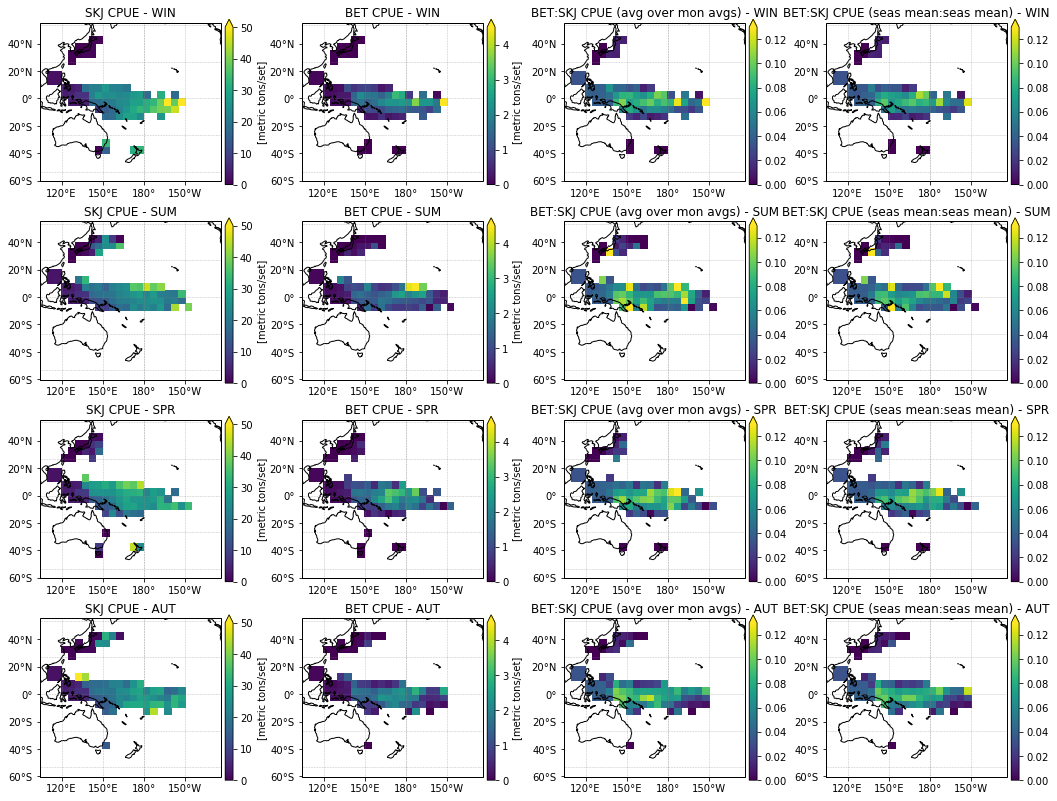

In [13]:
unitsnow = '[metric tons/set]'
seasnumdict = {0:'WIN', 1:'SUM', 2:'SPR', 3:'AUT'}
cm.viridis._rgba_over = None; #cm.viridis._rgba_under = None;
cm.viridis._set_extremes() 

# - Set proj and define axes
fig,axes = plt.subplots(nrows=4, ncols=4, figsize=(18,14), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty + plot
for irow in range(axes.shape[0]):
    for icol in range(axes.shape[1]):
        ax = axes[irow][icol]
        exec(open("create_map_bgs.py").read())
        if icol==0:
            skj_cp_tot_seas.isel(season=irow).plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cm.viridis, vmin=0, vmax=50,
                cbar_kwargs={'pad': 0.02, 'label': unitsnow, 'extend': 'max'})
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('SKJ CPUE - ' + seasnumdict[irow])
        elif icol==1: 
            bet_cp_tot_seas.isel(season=irow).plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cm.viridis, vmin=0, vmax=4.5,
                cbar_kwargs={'pad': 0.02, 'label': unitsnow, 'extend': 'max'})
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('BET CPUE - ' + seasnumdict[irow])
        elif icol==2: 
            bettoskj_cp_tot_seas.isel(season=irow).plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cm.viridis, vmin=0, vmax=0.13,
                cbar_kwargs={'pad': 0.02, 'label': '', 'extend': 'max'})
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('BET:SKJ CPUE (avg over mon avgs) - ' + seasnumdict[irow])
        elif icol==3: 
            (bet_cp_tot_seas.isel(season=irow)/skj_cp_tot_seas.isel(season=irow)).plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cm.viridis, vmin=0, vmax=0.13,
                cbar_kwargs={'pad': 0.02, 'label': '', 'extend': 'max'})
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('BET:SKJ CPUE (seas mean:seas mean) - ' + seasnumdict[irow])
        
#fig.savefig(figpath + 'question2a_bscpue_seasmeans.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

# Question 2abce ENSO from 9/19/19 in written lab notebook

In [89]:
# test1 = skj_cp_tot_anom[onienln==1]
# test1.mean(dim='time').plot()
# timesnow = oni[onienln==1].time
# skj_cp_tot_anom.sel(time=timesnow).mean(dim='time').plot()
# test = skj_cp_tot_anom[onienln==1].mean(dim='time')
# oni.time

### Compute EN vs. LN p-val maps

In [12]:
alphafdr = 0.1

skj_cp_tot_anom_enln_wrs_pval = wrspvalmap_loop(
    skj_cp_tot_anom[onienln==1],skj_cp_tot_anom[onienln==-1],'skj_cp_tot_anom_enln')
skj_cp_tot_anom_enln_wrs_ptf = controlfdr(skj_cp_tot_anom_enln_wrs_pval,alphafdr) 

bet_cp_tot_anom_enln_wrs_pval = wrspvalmap_loop(
    bet_cp_tot_anom[onienln==1],bet_cp_tot_anom[onienln==-1],'bet_cp_tot_anom_enln')
bet_cp_tot_anom_enln_wrs_ptf = controlfdr(bet_cp_tot_anom_enln_wrs_pval,alphafdr) 

bettoskj_cp_tot_anom_enln_wrs_pval = wrspvalmap_loop(
    bettoskj_cp_tot_anom[onienln==1],bettoskj_cp_tot_anom[onienln==-1],'bettoskj_cp_tot_anom_enln')
bettoskj_cp_tot_anom_enln_wrs_ptf = controlfdr(bettoskj_cp_tot_anom_enln_wrs_pval,alphafdr)

bettoskj2_cp_tot_anom_enln_wrs_pval = wrspvalmap_loop(
    (skj_cp_tot_anom[onienln==1]/bet_cp_tot_anom[onienln==1]
    ),(skj_cp_tot_anom[onienln==-1]/bet_cp_tot_anom[onienln==-1]),'bettoskj2_cp_tot_anom_enln')
bettoskj2_cp_tot_anom_enln_wrs_ptf = controlfdr(bettoskj2_cp_tot_anom_enln_wrs_pval,alphafdr)

### Compute correlations vs. ONI maps

In [13]:
oni3d,_=xr.broadcast(oni,skj_cp_tot)

In [14]:
alphafdr = 0.1

[_, _, _, skjvsoni_cp_tot_anom_cc, skjvsoni_cp_tot_anom_cc_pval, _
]=gettemprcmap_loop(oni3d,skj_cp_tot_anom,'skjvsoni_cp_tot_anom')
skjvsoni_cp_tot_anom_cc_ptf = controlfdr(skjvsoni_cp_tot_anom_cc_pval,alphafdr)

[_, _, _, betvsoni_cp_tot_anom_cc, betvsoni_cp_tot_anom_cc_pval, _
]=gettemprcmap_loop(oni3d,bet_cp_tot_anom,'betvsoni_cp_tot_anom')
betvsoni_cp_tot_anom_cc_ptf = controlfdr(betvsoni_cp_tot_anom_cc_pval,alphafdr)

[_, _, _, bettoskjvsoni_cp_tot_anom_cc, bettoskjvsoni_cp_tot_anom_cc_pval, _
]=gettemprcmap_loop(oni3d,bettoskj_cp_tot_anom,'bettoskjvsoni_cp_tot_anom')
bettoskjvsoni_cp_tot_anom_cc_ptf = controlfdr(bettoskjvsoni_cp_tot_anom_cc_pval,alphafdr)

[_, _, _, bettoskj2vsoni_cp_tot_anom_cc, bettoskj2vsoni_cp_tot_anom_cc_pval, _
]=gettemprcmap_loop(oni3d,skj_cp_tot_anom/bet_cp_tot_anom,'bettoskj2vsoni_cp_tot_anom')
#bettoskj2vsoni_cp_tot_anom_cc_ptf = controlfdr(bettoskj2vsoni_cp_tot_anom_cc_pval,alphafdr)
# --> the above doesn't work b/c no pvals are >= alphafdr*(i/N) :(, ask Wilks 2016 about this maybe?
bettoskj2vsoni_cp_tot_anom_cc_ptf = 0.05

### Plot maps

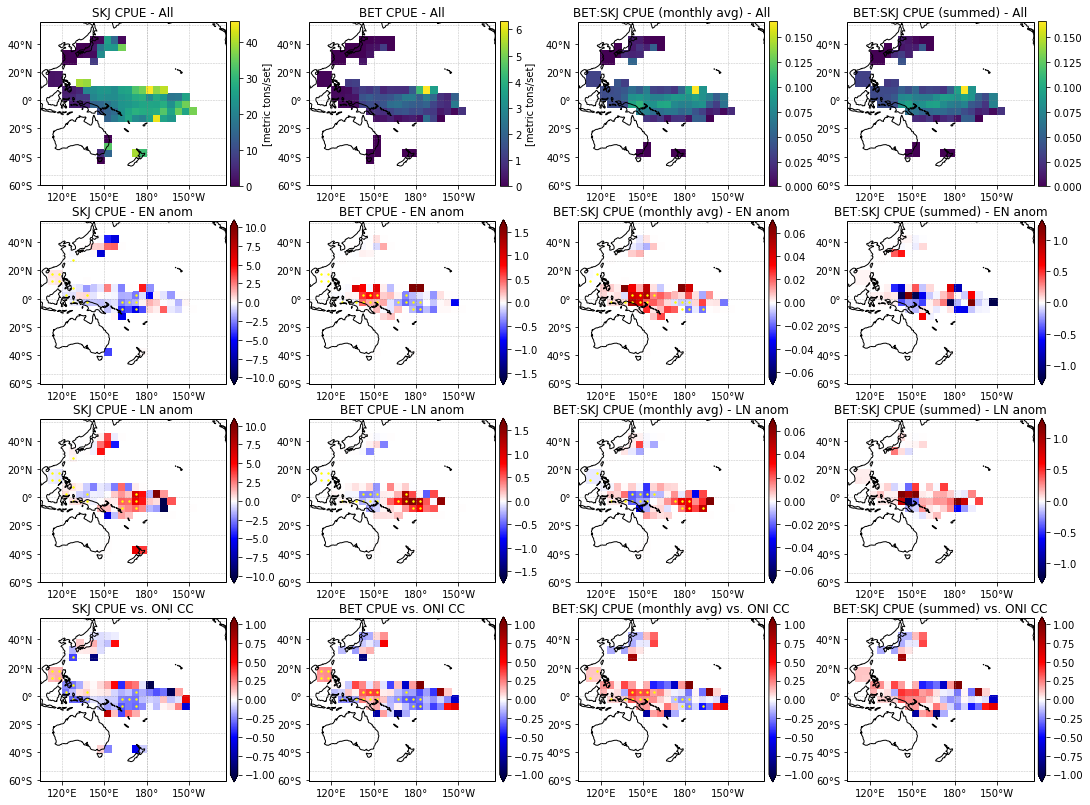

In [56]:
cm.viridis._rgba_over = None; #cm.viridis._rgba_under = None;
cm.viridis._set_extremes() 

# - Set proj and define axes
fig,axes = plt.subplots(nrows=4, ncols=4, figsize=(18.5,14), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# - Make maps pretty + plot
for irow in range(axes.shape[0]):

    if irow==0: # all times
        cmnow = cm.viridis; timelabelnow = ' - All'; extendnow='neither'; unitsnow = '[metric tons/set]'
        skj_cp_tot_now = skj_cp_tot.mean(dim='time'); vmin1=skj_cp_tot_now.min(); vmax1=skj_cp_tot_now.max();
        bet_cp_tot_now = bet_cp_tot.mean(dim='time'); vmin2=bet_cp_tot_now.min(); vmax2=bet_cp_tot_now.max();
        bettoskj_cp_tot_now = bettoskj_cp_tot.mean(dim='time'); vmin3=bettoskj_cp_tot_now.min(); vmax3=bettoskj_cp_tot_now.max(); 
        bettoskj_totcp_tot_now = (bet_cp_tot.sum(dim='time'))/(skj_cp_tot.sum(dim='time')); vmin4=bettoskj_totcp_tot_now.min(); vmax4=bettoskj_totcp_tot_now.max();
        signifstipplenow=0;
    elif irow==1: # el nino
        cmnow = cm.seismic; timelabelnow = ' - EN anom'; extendnow = 'both'; unitsnow = ''
        skj_cp_tot_now = skj_cp_tot_anom[onienln==1].mean(dim='time'); vmin1=-10; vmax1=10;
        bet_cp_tot_now = bet_cp_tot_anom[onienln==1].mean(dim='time'); vmin2=-1.6; vmax2=1.6;
        bettoskj_cp_tot_now = bettoskj_cp_tot_anom[onienln==1].mean(dim='time'); vmin3=-0.065; vmax3=0.065;
        #bettoskj2_cp_tot_now = (skj_cp_tot_anom[onienln==1]/bet_cp_tot_anom[onienln==1]
        #                      ).mean(dim='time'); vmin4=bettoskj_totcp_tot_now.min(); vmax4=bettoskj_totcp_tot_now.max();
        bettoskj_totcp_tot_now = (bet_cp_tot_anom[onienln==1].sum(dim='time')
                                 )/(skj_cp_tot_anom[onienln==1].sum(dim='time')); vmin4=-1.2; vmax4=1.2;
        signifstipplenow=1;
        skj_cp_tot_pv_now = skj_cp_tot_anom_enln_wrs_pval; skj_cp_tot_ptf_now = skj_cp_tot_anom_enln_wrs_ptf; 
        bet_cp_tot_pv_now = bet_cp_tot_anom_enln_wrs_pval; bet_cp_tot_ptf_now = bet_cp_tot_anom_enln_wrs_ptf; 
        bettoskj_cp_tot_pv_now = bettoskj_cp_tot_anom_enln_wrs_pval; bettoskj_cp_tot_ptf_now = bettoskj_cp_tot_anom_enln_wrs_ptf; 
    elif irow==2: # la nina
        cmnow = cm.seismic; timelabelnow = ' - LN anom'; extendnow = 'both'; unitsnow = ''
        skj_cp_tot_now = skj_cp_tot_anom[onienln==-1].mean(dim='time'); vmin1=-10; vmax1=10;
        bet_cp_tot_now = bet_cp_tot_anom[onienln==-1].mean(dim='time'); vmin2=-1.6; vmax2=1.6;
        bettoskj_cp_tot_now = bettoskj_cp_tot_anom[onienln==-1].mean(dim='time'); vmin3=-0.065; vmax3=0.065;
        #bettoskj2_cp_tot_now = (skj_cp_tot_anom[onienln==-1]/bet_cp_tot_anom[onienln==-1]
        #                      ).mean(dim='time'); vmin4=bettoskj_totcp_tot_now.min(); vmax4=bettoskj_totcp_tot_now.max();
        bettoskj_totcp_tot_now = (bet_cp_tot_anom[onienln==-1].sum(dim='time')
                                 )/(skj_cp_tot_anom[onienln==-1].sum(dim='time')); vmin4=-1.2; vmax4=1.2;
        signifstipplenow=1;
        skj_cp_tot_pv_now = skj_cp_tot_anom_enln_wrs_pval; skj_cp_tot_ptf_now = skj_cp_tot_anom_enln_wrs_ptf; 
        bet_cp_tot_pv_now = bet_cp_tot_anom_enln_wrs_pval; bet_cp_tot_ptf_now = bet_cp_tot_anom_enln_wrs_ptf; 
        bettoskj_cp_tot_pv_now = bettoskj_cp_tot_anom_enln_wrs_pval; bettoskj_cp_tot_ptf_now = bettoskj_cp_tot_anom_enln_wrs_ptf; 
    elif irow==3: # oni correls
        cmnow = cm.seismic; timelabelnow = ' vs. ONI CC'; extendnow = 'both'; unitsnow = ''
        skj_cp_tot_now = skjvsoni_cp_tot_anom_cc; vmin1=-1; vmax1=1;
        bet_cp_tot_now = betvsoni_cp_tot_anom_cc; vmin2=-1; vmax2=1;
        bettoskj_cp_tot_now = bettoskjvsoni_cp_tot_anom_cc; vmin3=-1; vmax3=1;
        #bettoskj2_cp_tot_now = bettoskj2vsoni_cp_tot_anom_cc; vmin4=bettoskj_totcp_tot_now.min(); vmax4=bettoskj_totcp_tot_now.max();
        bettoskj_totcp_tot_now = bettoskjvsoni_cp_tot_anom_cc; vmin4=-1; vmax4=1; # a repeat of bettoskj_cp_tot_now here
        signifstipplenow=1;
        skj_cp_tot_pv_now = skjvsoni_cp_tot_anom_cc_pval; skj_cp_tot_ptf_now = skjvsoni_cp_tot_anom_cc_ptf; 
        bet_cp_tot_pv_now = betvsoni_cp_tot_anom_cc_pval; bet_cp_tot_ptf_now = betvsoni_cp_tot_anom_cc_ptf; 
        bettoskj_cp_tot_pv_now = bettoskjvsoni_cp_tot_anom_cc_pval; bettoskj_cp_tot_ptf_now = bettoskjvsoni_cp_tot_anom_cc_ptf; 
        
    for icol in range(axes.shape[1]):
        ax = axes[irow][icol]
        exec(open("create_map_bgs.py").read())
        if icol==0:
            skj_cp_tot_now.plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cmnow, vmin=vmin1, vmax=vmax1,
                cbar_kwargs={'pad': 0.02, 'label': unitsnow, 'extend': extendnow})
            if signifstipplenow==1:
                [signiflonnow,signiflatnow]=find_where_pval_small(
                    skj_cp_tot_anom_enln_wrs_pval,skj_cp_tot_anom_enln_wrs_ptf)
                ax.scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('SKJ CPUE' + timelabelnow)
        elif icol==1: 
            bet_cp_tot_now.plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cmnow, vmin=vmin2, vmax=vmax2,
                cbar_kwargs={'pad': 0.02, 'label': unitsnow, 'extend': extendnow})
            if signifstipplenow==1:
                [signiflonnow,signiflatnow]=find_where_pval_small(
                    bet_cp_tot_anom_enln_wrs_pval,bet_cp_tot_anom_enln_wrs_ptf)
                ax.scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('BET CPUE' + timelabelnow)
        elif icol==2: 
            bettoskj_cp_tot_now.plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cmnow, vmin=vmin3, vmax=vmax3,
                cbar_kwargs={'pad': 0.02, 'label': '', 'extend': extendnow})
            if signifstipplenow==1:
                [signiflonnow,signiflatnow]=find_where_pval_small(
                    bettoskj_cp_tot_anom_enln_wrs_pval,bettoskj_cp_tot_anom_enln_wrs_ptf)
                ax.scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('BET:SKJ CPUE (monthly avg)' + timelabelnow)
        elif icol==3: 
            #bettoskj2_cp_tot_now.plot(
            bettoskj_totcp_tot_now.plot(
                ax=ax, transform=ccrs.PlateCarree(), cmap=cmnow, vmin=vmin4, vmax=vmax4,
                cbar_kwargs={'pad': 0.02, 'label': '', 'extend': extendnow})
            #if signifstipplenow==1:
            #    [signiflonnow,signiflatnow]=find_where_pval_small(
            #        bettoskj2_cp_tot_anom_enln_wrs_pval,bettoskj2_cp_tot_anom_enln_wrs_ptf)
            #    ax.scatter(signiflonnow, signiflatnow, c='yellow', s=2, transform=ccrs.PlateCarree());
            ax.set_xlabel(''); ax.set_ylabel('');
            ax.set_title('BET:SKJ CPUE (summed)' + timelabelnow)
       
fig.savefig(figpath + 'question2a_bscpue_ensomeans.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

# Question 2g ENSO from 9/19/19 in written lab notebook

In [18]:
import descartes
import regionmask
regionmask.__version__

'0.4.0'

In [157]:
eezs = gpd.read_file(
    dpath + 'EEZs/World_EEZ_v9_20161021_HR_0_360/World_EEZ_v9_2016_HR_0_360_PNA_and_ETP_ctries_only.shp')
nuctries = ['Palau','Micronesia','Papua New Guinea','Solomon Islands','Nauru','Marshall Islands','Tuvalu','Kiribati'];
nueezs = ['Palau','Micronesia','Papua New Guinea','Solomon Islands','Nauru','Marshall Islands',
          'Kiribati (Gilbert Islands)','Tuvalu','Kiribati (Phoenix Islands)','Kiribati (Line Islands)'];
etpctries = ['Peru','Ecuador','Colombia','Panama','Costa Rica','Nicaragua','El Salvador','Guatemala'];
eezsnu = eezs[eezs['Sovereign1'].isin(nuctries)]

In [159]:
numbers = list(range(0,len(eezs)))
names = eezs.Sovereign1.values
names[16] = 'Kiribati (Phoenix Islands)'
names[21] = 'Kiribati (Line Islands)'
names[22] = 'Kiribati (Gilbert Islands)'
abbrevs = [w[0:4] for w in eezs.Sovereign1.values]
masknow = regionmask.Regions_cls('mask', numbers, names, abbrevs, eezs.geometry)
eezmask = masknow.mask(lon,lat, wrap_lon=False)

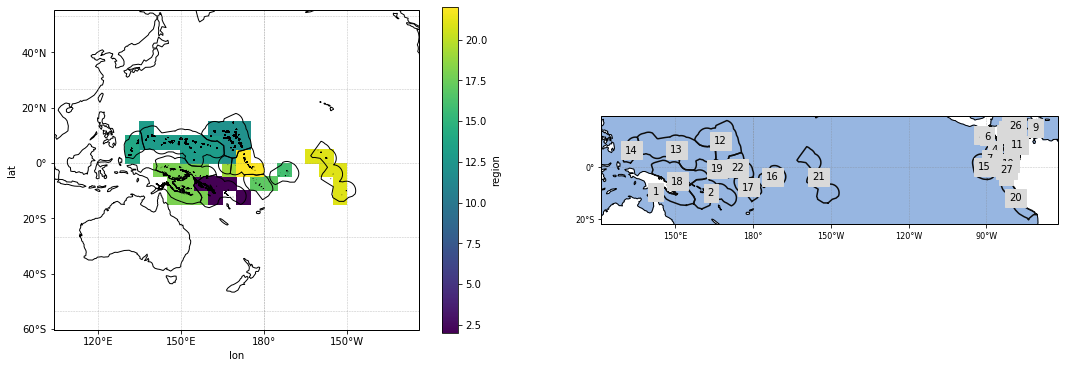

In [161]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)})

# ------ Plot 
ax = axes[0]
# - Add coastlines
ax.coastlines();
# - Add gridlines
xlocsnow = np.concatenate([np.linspace(120,180,3),np.linspace(-180,-90,4)]) # needs 180,-180 repeated to make y lines go through
xlocsnow = np.append(xlocsnow,-70) # for some reason -90 won't plot w/o this
ylocsnow = np.linspace(-80,80,7)
ylocsnow = np.append(ylocsnow,90); ylocsnow = np.insert(ylocsnow,0,-90) # to make x lines go through
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, # take care of labels below
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(xlocsnow); gl.ylocator = mticker.FixedLocator(ylocsnow)
# - Add lat and lon labels
xticksnow = np.concatenate([np.linspace(120,180,3),np.linspace(-150,-90,3)]) # get rid of repeated 180,-180
yticksnow = np.linspace(-80,80,9) # get rid of -90,90
ax.set_xticks(xticksnow, crs=ccrs.PlateCarree())
ax.set_yticks(yticksnow, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
eezmask.plot(ax=ax, transform=ccrs.PlateCarree());
eezsnu.plot(ax=ax, transform=ccrs.PlateCarree(), edgecolor='black', color='none', linewidth=1);

# ------ Plot 
ax = axes[1]
# - Add gridlines
xlocsnow = np.concatenate([np.linspace(120,180,3),np.linspace(-180,-90,4)]) # needs 180,-180 repeated to make y lines go through
xlocsnow = np.append(xlocsnow,-70) # for some reason -90 won't plot w/o this
ylocsnow = np.linspace(-80,80,7)
ylocsnow = np.append(ylocsnow,90); ylocsnow = np.insert(ylocsnow,0,-90) # to make x lines go through
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, # take care of labels below
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(xlocsnow); gl.ylocator = mticker.FixedLocator(ylocsnow)
# - Add lat and lon labels
xticksnow = np.concatenate([np.linspace(120,180,3),np.linspace(-150,-90,3)]) # get rid of repeated 180,-180
yticksnow = np.linspace(-80,80,9) # get rid of -90,90
ax.set_xticks(xticksnow, crs=ccrs.PlateCarree())
ax.set_yticks(yticksnow, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
masknow.plot(ax=ax);

In [162]:
df_enn = pd.DataFrame({'names':names, 'numbers':numbers}) #df_eeznamesnumbers
df_enn

,names,numbers
0,Peru,0
1,Papua New Guinea,1
2,Solomon Islands,2
3,Panama,3
4,Costa Rica,4
5,Guatemala,5
6,El Salvador,6
7,Costa Rica,7
8,Nicaragua,8
9,Colombia,9


In [254]:
def get_allenln_values(varnow):
    varallnow = []
    varennow = []
    varlnnow = []
    for ieez in range(0,len(nueezs)):
        eeznumsnow = df_enn['numbers'][df_enn['names']==nueezs[ieez]].values
        allnow = varnow.where(np.isin(eezmask,eeznumsnow)).values
        allnow = allnow[~np.isnan(allnow)]
        ennow = varnow[onienln==1].where(np.isin(eezmask,eeznumsnow)).values
        ennow = ennow[~np.isnan(ennow)]
        lnnow = varnow[onienln==-1].where(np.isin(eezmask,eeznumsnow)).values
        lnnow = lnnow[~np.isnan(lnnow)]
        varallnow.append(allnow)
        varennow.append(ennow)
        varlnnow.append(lnnow)
    return varallnow, varennow, varlnnow;

In [282]:
skj_cp_tot_all_nueezs,skj_cp_tot_en_nueezs,skj_cp_tot_ln_nueezs = get_allenln_values(skj_cp_tot)
bet_cp_tot_all_nueezs,bet_cp_tot_en_nueezs,bet_cp_tot_ln_nueezs = get_allenln_values(bet_cp_tot)
bettoskj_cp_tot_all_nueezs,bettoskj_cp_tot_en_nueezs,bettoskj_cp_tot_ln_nueezs = get_allenln_values(bettoskj_cp_tot)
skjmbet_cp_tot_all_nueezs,skjmbet_cp_tot_en_nueezs,skjmbet_cp_tot_ln_nueezs = get_allenln_values(skj_cp_tot-bet_cp_tot)

In [ ]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [296]:
nueezs_abbrev = ['PLW','FSM','PNG','SLB','NRU','MHL','KIR-G','TUV','KIR-P','KIR-L']

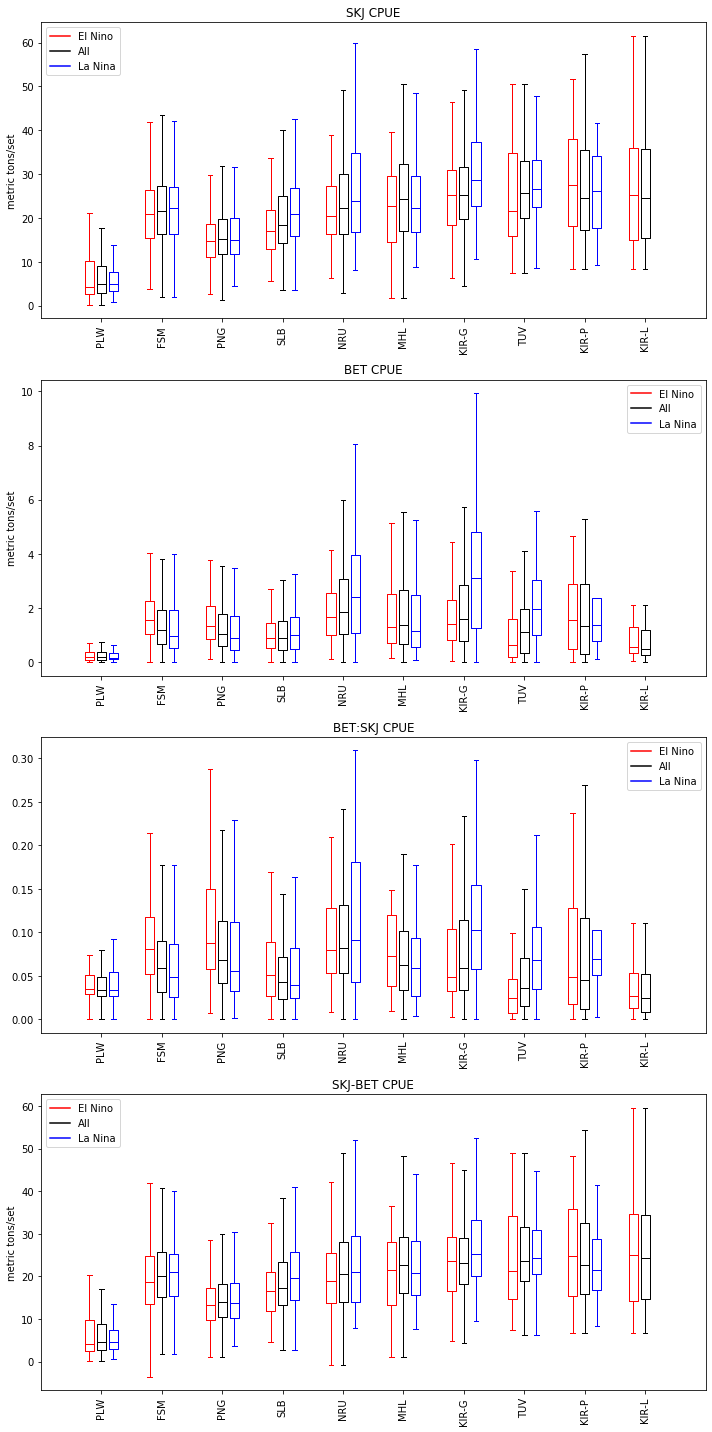

In [304]:
ticks = nueezs_abbrev
fig,axes=plt.subplots(nrows=4,ncols=1,figsize=(10,20))

# - SKJ CPUE
axnow = axes[0]; titlenow = 'SKJ CPUE'; unitsnow = 'metric tons/set'
ennow = skj_cp_tot_en_nueezs; allnow = skj_cp_tot_all_nueezs; lnnow = skj_cp_tot_ln_nueezs
exec(open("enln_boxplots.py").read())

# - BET CPUE
axnow = axes[1]; titlenow = 'BET CPUE'; unitsnow = 'metric tons/set'
ennow = bet_cp_tot_en_nueezs; allnow = bet_cp_tot_all_nueezs; lnnow = bet_cp_tot_ln_nueezs
exec(open("enln_boxplots.py").read())

# - BET:SKJ CPUE
axnow = axes[2]; titlenow = 'BET:SKJ CPUE'; unitsnow = ''
ennow = bettoskj_cp_tot_en_nueezs; allnow = bettoskj_cp_tot_all_nueezs; lnnow = bettoskj_cp_tot_ln_nueezs
exec(open("enln_boxplots.py").read())

# - SKJ MINUS BET CPUE
axnow = axes[3]; titlenow = 'SKJ-BET CPUE'; unitsnow = 'metric tons/set'
ennow = skjmbet_cp_tot_en_nueezs; allnow = skjmbet_cp_tot_all_nueezs; lnnow = skjmbet_cp_tot_ln_nueezs
exec(open("enln_boxplots.py").read())

fig.savefig(figpath + 'question2g_bscpue_ensoboxplot.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

In [ ]:
#options to cut netcdf w/ shapefile are 
# salem: https://salem.readthedocs.io/en/latest/examples.html, https://salem.readthedocs.io/en/latest/xarray_acc.html#regions-of-interest
# regionmask: https://regionmask.readthedocs.io/en/stable/_static/notebooks/create_own_regions.html, https://gis.stackexchange.com/questions/289775/python-mask-netcdf-data-using-shapefile-xarray-geopandas
# rioxarray: https://corteva.github.io/rioxarray/html/examples/clip_geom.html, https://gis.stackexchange.com/questions/328128/extracting-data-within-geometry-shape
# other useful: https://gis.stackexchange.com/questions/289775/python-mask-netcdf-data-using-shapefile-xarray-geopandas
# stephan hoyer: https://stackoverflow.com/questions/51398563/python-mask-netcdf-data-using-shapefile, https://github.com/pydata/xarray/issues/501

# Notes

In [ ]:
# THIS IS AN AWESOME CARTOPY/MATPLOTLIB PLOTTING GUIDE --> https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
# great gridlines formatting guide --> https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
# great lon labels formatting guide --> https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
# cbar kwargs --> https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.colorbar.html)

In [6]:
# # - Specific example w/ skj_cp_tot and bet_cp_tot
# x3dnow=skj_cp_tot; y3dnow=bet_cp_tot
# # - The following pts gave the PearsonRConstantInputWarning,
# can check lats, lons of these pts to make sure bet_cp_tot_all_zeros_lon/lat are right: 
# ilat=3;ilon=13;xnow=x3dnow[:,ilat,ilon];ynow=y3dnow[:,ilat,ilon]
# #ilat=19;ilon=10;xnow=x3dnow[:,ilat,ilon];ynow=y3dnow[:,ilat,ilon]
# # - Find spatial pts where all bet cpue values over time are zero
# # and where all bet cpue values are not nan
# bet_cp_tot_sum=bet_cp_tot.sum(dim='time', skipna=True).where(~xr.ufuncs.isnan(bet_cp_tot_mean))
# bet_cp_tot_sum_zero=bet_cp_tot_sum.where(bet_cp_tot_sum==0)
# # - Get lat,lon where zeros are (https://stackoverflow.com/questions/40592630/get-coordinates-of-non-nan-values-of-xarray-dataset)
# bet_cp_tot_sum_zero_stacked = bet_cp_tot_sum_zero.stack(x=['lat','lon'])
# bet_cp_tot_all_zeros=bet_cp_tot_sum_zero_stacked[bet_cp_tot_sum_zero_stacked.notnull()]
# # - Look at time series at the computed lats/lons to make sure all non-nan values are zero
# #for i in range(bet_cp_tot_all_zeros.size):
# #    print(bet_cp_tot.sel(lat=bet_cp_tot_all_zeros.lat[i], lon=bet_cp_tot_all_zeros.lon[i]))

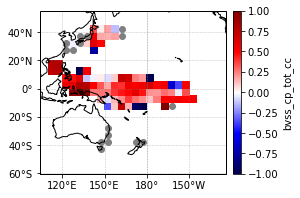

In [18]:
# - ORIGINAL, WITH JUST ONE SUBPLOT

plt.figure(figsize=(6,3))

# - Set proj and define axes
projectionnow = ccrs.PlateCarree(central_longitude=200)
ax = plt.axes(projection=projectionnow)
ax.coastlines();

# - Add gridlines
xlocsnow = np.concatenate([np.linspace(120,180,3),np.linspace(-180,-150,2)]) # needs 180,-180 repeated to make y lines go through
xlocsnow = np.append(xlocsnow,-70) # for some reason -150 won't plot w/o this
ylocsnow = np.linspace(-80,80,9)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, # take care of labels below
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False; gl.ylabels_right = False;
gl.xlines = True; gl.ylines=True;
gl.xlocator = mticker.FixedLocator(xlocsnow); gl.ylocator = mticker.FixedLocator(ylocsnow)

# - Add lat and lon labels
xticksnow = np.concatenate([np.linspace(120,180,3),np.linspace(-150,-90,3)]) # get rid of repeated 180,-180
yticksnow = np.linspace(-80,80,9)
ax.set_xticks(xticksnow, crs=ccrs.PlateCarree())
ax.set_yticks(yticksnow, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# - Plot
#ax.pcolormesh(lon,lat,bvss_cp_tot_cc, transform=ccrs.PlateCarree(), cmap=cm.seismic); # wrong offset by 5 deg lon :(
bvss_cp_tot_cc.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cm.seismic, cbar_kwargs={'pad': 0.02});
ax.scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, c='gray', transform=ccrs.PlateCarree());

# - Final touches
ax.set_xlabel(''); ax.set_ylabel('');

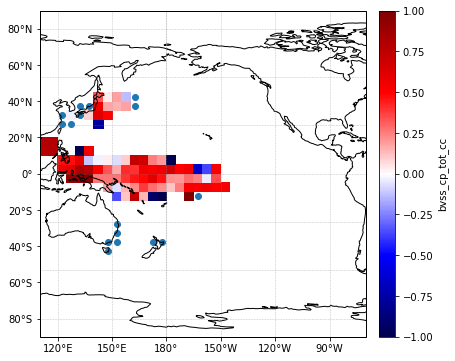

In [19]:
plt.figure(figsize=(12,6))

# - Set proj and define axes
projectionnow = ccrs.PlateCarree(central_longitude=200)
ax = plt.axes(projection=projectionnow)
ax.coastlines();

# - Set extent
extentnow = [110, 290, -50, 50] # for some reason this is really finnicky
ax.set_extent(extentnow)

# - Add gridlines
xlocsnow = np.concatenate([np.linspace(120,180,3),np.linspace(-180,-90,4)]) # needs 180,-180 repeated to make y lines go through
xlocsnow = np.append(xlocsnow,-70) # for some reason -90 won't plot w/o this
ylocsnow = np.linspace(-80,80,7)
ylocsnow = np.append(ylocsnow,90); ylocsnow = np.insert(ylocsnow,0,-90) # to make x lines go through
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, # take care of labels below
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False; gl.ylabels_right = False;
gl.xlines = True; gl.ylines=True;
gl.xlocator = mticker.FixedLocator(xlocsnow); gl.ylocator = mticker.FixedLocator(ylocsnow)
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 15, 'color': 'gray', 'weight': 'bold'}; gl.ylabel_style = {'size': 15, 'color': 'gray', 'weight': 'bold'};

# - Add lat and lon labels
xticksnow = np.concatenate([np.linspace(120,180,3),np.linspace(-150,-90,3)]) # get rid of repeated 180,-180
yticksnow = np.linspace(-80,80,9) # get rid of -90,90
ax.set_xticks(xticksnow, crs=ccrs.PlateCarree())
ax.set_yticks(yticksnow, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# - Plot
#ax.pcolormesh(lon,lat,bvss_cp_tot_cc, transform=ccrs.PlateCarree(), cmap=cm.seismic); # wrong offset by 5 deg lon :(
bvss_cp_tot_cc.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cm.seismic, cbar_kwargs={'pad': 0.02});
ax.scatter(bet_cp_tot_all_zeros_lon, bet_cp_tot_all_zeros_lat, transform=ccrs.PlateCarree());

# - Final touches
ax.set_xlabel(''); ax.set_ylabel('');

In [169]:
x3dnow = skj_cp_tot_anom[onienln==-1]
y3dnow = skj_cp_tot_anom[onienln==1]
pval2dnow = xr.full_like(x3dnow.mean(dim='time'), np.nan)
ilon=13; ilat=11
xnow = x3dnow[:,ilat,ilon]
ynow = y3dnow[:,ilat,ilon]
xvalsnow = (~xr.ufuncs.isnan(xnow))&(~xr.ufuncs.isinf(xnow))
yvalsnow = (~xr.ufuncs.isnan(ynow))&(~xr.ufuncs.isinf(ynow))
wrsnow = stats.ranksums(xnow[xvalsnow],ynow[yvalsnow])

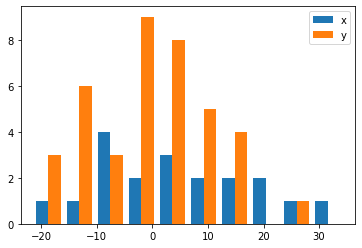

In [165]:
plt.hist([xnow[xvalsnow],ynow[yvalsnow]], label=['x','y']);
plt.legend(loc='upper right');